### PII obfuscation and removal

Removing PII from sensitive data sources is imperative in many settings, especially when handling customer data from GDPR protected countries. Merely ensuring secure and encrypted use of PII information isn't necessarily enough and depending on your use-case it may need to be removed entirely. This is due to the fact that not only should PII data be protected, however the information should only be processed when it is absolutely necessary as mandated by the data minimization clause. Thus only when PII data is meaningfully relevant to the system or process that is using the data then that PII data may be included. 

In many areas of NLP the PII information itself isn't stricly relevant or necessary for extracting the information or performing classification that we desire from the text. This can include sentiment classification, summarization, extracting key subjects or conversation elements etc. Removing PII in this context does not necessarily detract from the ability to perform many useful NLP functions.

Additionally, the use of external API's like ChatGPT can be cause for some concern when sending sensitive customer information. This may be due to the potential for PII information to be leaked and/or simply due to company policies involving the processing of customer information.

Whatever the unique scenario, knowing how to develop a model which can perform PII obfuscation is very useful and there are advantages for creating your own. There are powerful smaller langauge models which are very capable of performing this task and will have no additional token processing cost as with GPT3.5 / GPT4 / Bard etc. and certain models may outright refuse requests related to PII due to their alignment finetuning to even perform a task in this area, such as with Llama2 etc.

In this notebook I will demonstrate firstly how to generate some dummy PII data and then how you can prepare that data for fine tuning a smaller neural net via transfer learning to perform obfuscation.

In [1]:
import os
import openai
import json
import re
import time
import pandas as pd

In [2]:
openai.api_key = os.getenv("OPEN_AI")

Generating training data using Chat GPT

Here GPT 4o mini was used for cost minimization, the task is also not too complex thus does not warrant the need for a more complex GPT 4 variant.

The temperature was set to a high value to encourage creativity. 

In [3]:
def generate_response(messages, model="gpt-4o-mini", temperature=0.7, 
                      max_tokens=3100, response_format=None):
    
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens,
        response_format=response_format
        
    )
    
    return response.choices[0].message['content']

A simple system message, this is reusable and can be combined with more dynamic user inputs

In [4]:
def generate_examples(user_input, temperature, response_format=None):
    
    system_message = '''
    You are a helpful and creative assistant, you follow instructions closely, your outputs form part of a system and thus need to adhere to requirements closely.
    '''
    messages = [
        {'role': 'system', 'content': system_message},
        {'role': 'user', 'content': user_input}
    ]
    
    return generate_response(messages=messages, temperature=temperature, response_format=response_format)

In [12]:
user_input = '''
Please generate some fake messages that will be used for testing a PII detection model.

The output needs to be in the form of a interaction between a customer service representative and a customer.

Generate 10 examples of such interactions, ensure that the conversation is natural and somewhat varied in content.

The PII that needs to be generated includes: [Names, User names, Emails, Phone numbers, Date of birth, Addresses]

The examples need to use a varied combination of these, use at least 2 different types within a given example.

In each example ensure that a different customer name is used.

Respond only with the messages, denote the start of each response as either Host: or Customer: 

Each example should be a single continuous string

Output the examples in a JSON format and use the key: GeneratedMessages

Respond only with the JSON object, do not include ```json ... ``` in your response

'''

In [13]:
%%time
examples = generate_examples(user_input, temperature=0.7)

CPU times: total: 0 ns
Wall time: 5.34 s


In [14]:
len(json.loads(examples)['GeneratedMessages'])

10

OpenAI have set a rate limit on the number of tokens that can be generated per minute, thus I have used a simple sleep of 5 seconds to try and offset that and prevent failures in the loop.

Since one set has already been created, that can be added to the list, 10 examples can then be used as a small validation set with 50 for training in this small demonstration

In [15]:
%%time
GeneratedMessages = []
GeneratedMessages+=json.loads(examples)['GeneratedMessages']

for _ in range(5):
    examples = generate_examples(user_input, temperature=0.7, response_format={ "type": "json_object"})
    GeneratedMessages+=json.loads(examples)['GeneratedMessages']
    time.sleep(5)

CPU times: total: 0 ns
Wall time: 1min 19s


In [16]:
len(GeneratedMessages)

60

### Storing examples

This process can be run repeatedly, each time creating more samples

Once run, these can be collected within a csv and each new example can be appended to the existing ones. 

It is interesting to note that duplicates may occcur, thus dropping these before saving each time will ensure no data leakage when using these within training.

In [17]:
loaded_examples = pd.read_csv('GeneratedPII_sample.csv')

In [18]:
loaded_examples.columns = ['GeneratedMessages']

In [19]:
gen_examples = pd.DataFrame(GeneratedMessages)
gen_examples.columns = ['GeneratedMessages']

In [20]:
GeneratedMessages = pd.concat([gen_examples, loaded_examples], axis=0, sort=False)
GeneratedMessages.reset_index(inplace=True, drop=True)

In [21]:
GeneratedMessages.drop_duplicates(inplace=True)
GeneratedMessages

,GeneratedMessages
0,"Host: Hello, thank you for contacting support!..."
1,Host: Good afternoon! What can I help you with...
2,Host: Welcome to customer support! What issue ...
3,Host: Thank you for reaching out! What can I d...
4,Host: Hello! How can I help you today? Custome...
...,...
215,"Customer: Hi, I’m Olivia Johnson. I was born o..."
216,Customer: Hello! My name is Liam Martinez. My ...
217,"Customer: Hi, I’m Sophia Anderson. My phone nu..."
218,"Customer: Good afternoon, this is Benjamin Tay..."


In [22]:
pd.DataFrame(GeneratedMessages).to_csv('GeneratedPII_sample.csv', index=False)

Next I opted for a few shot strategy to ensure that the model labels the data 100% as desired. 

I found instances where the labels were not correct and using the examples where GPT had failed, I included these within the few shot examples, this improved the label accuracy substantially with a detriment to token count.

In [23]:
def few_shot_obfuscate(user_input, temperature=0):
    
    system_message = '''
    Given the following interaction between a customer and host, the PII information needs to be obfuscated

    The message will be delimited by ####

    For each of the following forms of PII replace it with the associated token:
        names : NAME
        emails : EMAIL
        phone number : PHONE_NUMBER
        dates of birth: DOB
        user names : USERNAME
        addresses : ADDRESS

    If the PII is separated by a white space then replace each word individually with the specified token value
    
    The goal is to replace each individual word and number found in the PII
    
    Ensure that you do not remove punctuation when replacing

    Respond only with the obfuscated string 
    '''
    messages = [
        {'role': 'system', 'content': system_message},
        {'role': 'user', 'content': "####Host: Thank you for reaching out to us. How may I assist you today?\nCustomer: Hi, my name is David Smith and I'm having trouble with my delivery. My address is 123 Main St, Anytown, USA and my date of birth is 15 jan, 1990.\nHost: Hi David, I'm here to help. What seems to be the problem with your delivery?\nCustomer: I received the wrong item in my package and I need to return it. My phone number is 987-654-3210.\n####"},
        {'role': 'system', 'content': "Host: Thank you for reaching out to us. How may I assist you today?\nCustomer: Hi, my name is NAME NAME and I'm having trouble with my delivery. My address is ADDRESS ADDRESS ADDRESS, ADDRESS, ADDRESS and my date of birth is DOB DOB, DOB.\nHost: Hi NAME, I'm here to help. What seems to be the problem with your delivery?\nCustomer: I received the wrong item in my package and I need to return it. My phone number is PHONE_NUMBER.\n"},
        {'role': 'user', 'content': "####Host: Thank you for contacting our customer service. How can I assist you today?\nCustomer: Hi, my name is Michael Johnson and I have a question about my recent purchase. My email address is michaeljohnson@yahoo.com.\nHost: Hi Michael, I'm here to help. What's your question?\nCustomer: I received a damaged item and I need to request a replacement. My phone number is (555) 123-4567.####"},
        {'role': 'system', 'content': "Host: Thank you for contacting our customer service. How can I assist you today?\nCustomer: Hi, my name is NAME NAME and I have a question about my recent purchase. My email address is EMAIL.\nHost: Hi NAME, I'm here to help. What's your question?\nCustomer: I received a damaged item and I need to request a replacement. My phone number is PHONE_NUMBER PHONE_NUMBER."},
        {'role': 'user', 'content': "####Host: Welcome! How can I help you?\nCustomer: Hello, my name is Michael Anderson and I never received my order. My phone number is (987) 654-3210 and my address is 123 Main St.####"},
        {'role': 'system', 'content': "Host: Welcome! How can I help you?\nCustomer: Hello, my name is NAME NAME and I never received my order. My phone number is PHONE_NUMBER PHONE_NUMBER and my address is ADDRESS ADDRESS ADDRESS."},
        {'role': 'user', 'content': f"####{user_input}####"}
    ]
    
    return generate_response(messages=messages, temperature=temperature, model="gpt-4-turbo", response_format=None)

In [24]:
example = GeneratedMessages['GeneratedMessages'].to_list()[7]
example

"Host: Thank you for your message! How can I assist? Customer: I want to change my username. It's currently Mark_Taylor and I'd like it to be MarkTheGreat. Also, my phone number is 555-234-5678."

In [25]:
few_shot_obfuscate(example)

"Host: Thank you for your message! How can I assist? Customer: I want to change my username. It's currently USERNAME and I'd like it to be USERNAME. Also, my phone number is PHONE_NUMBER."

Next each example needs to be iteratively processed and captured, the below has a check to see how many examples have previously been processed, in case anything fails within the process and the obfuscation needs to be rerun, thus saving time and money on the API call.

In [26]:
obfuscated_examples = []
numberofexamples = len(GeneratedMessages)

In [27]:
for i, example in enumerate(GeneratedMessages['GeneratedMessages'].to_list()):
    i+=1
    if i <= len(obfuscated_examples):
        pass
    else: 
        output = few_shot_obfuscate(example)
        output = output.replace('#', '')
        obfuscated_examples.append(output)
        if i % 10 == 0 or i/numberofexamples==1:
            print(f'Finished example: {i}')
            print(f'{((i)/numberofexamples)*100}% complete')

Finished example: 10
4.545454545454546% complete
Finished example: 20
9.090909090909092% complete
Finished example: 30
13.636363636363635% complete
Finished example: 40
18.181818181818183% complete
Finished example: 50
22.727272727272727% complete
Finished example: 60
27.27272727272727% complete
Finished example: 70
31.818181818181817% complete
Finished example: 80
36.36363636363637% complete
Finished example: 90
40.909090909090914% complete
Finished example: 100
45.45454545454545% complete
Finished example: 110
50.0% complete
Finished example: 120
54.54545454545454% complete
Finished example: 130
59.09090909090909% complete
Finished example: 140
63.63636363636363% complete
Finished example: 150
68.18181818181817% complete
Finished example: 160
72.72727272727273% complete
Finished example: 170
77.27272727272727% complete
Finished example: 180
81.81818181818183% complete
Finished example: 190
86.36363636363636% complete
Finished example: 200
90.9090909090909% complete
Finished example: 

In [28]:
obfuscated_examples[:10]

["Host: Hello, thank you for contacting support! How can I assist you today? Customer: Hi, I'm trying to reset my password. My name is NAME NAME and my email is EMAIL.",
 'Host: Good afternoon! What can I help you with? Customer: I need help with my account. My username is USERNAME and my phone number is PHONE_NUMBER.',
 'Host: Welcome to customer support! What issue are you experiencing? Customer: Hi there, I just received a charge on my account. My address is ADDRESS ADDRESS ADDRESS, ADDRESS, and my DOB is DOB/DOB/DOB.',
 'Host: Thank you for reaching out! What can I do for you today? Customer: I want to update my email. My current email is EMAIL, but I want to change it to EMAIL.',
 'Host: Hello! How can I help you today? Customer: I have a question about my shipment. My name is NAME NAME, and my phone number is PHONE_NUMBER PHONE_NUMBER.',
 'Host: Hi! Thanks for contacting us. What can I assist you with? Customer: I need to verify my account. My username is USERNAME and my address 

Next the text within the obfuscated examples need to be prepared for the final labelling of each word. This preprocessing will ensure that punctuation receives a label that is independent to the token to which it sits adjacent to.

In [410]:
def prepare_text(text):
    text = re.sub(r'\.\s', ' . ', text)
    text = re.sub(r'\.\s*$', ' . ', text)
    text = re.sub(',', ' , ', text) 
    text = re.sub('\!', ' ! ', text)
    text = re.sub('\?', ' ? ', text)
    text = re.sub(r'\\n', ' \\n ', text)
    text = re.sub(r'{', ' ', text)
    text = re.sub(r'}', ' ', text)
    # correcting for a known invalid label pattern
    text = re.sub(r'DOB/DOB/DOB', 'DOB', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

In [411]:
test_text = "Host: Hello! How can I assist you today?\nCustomer: Hi, my name is NAME NAME and birth date is DOB/DOB/DOB. I recently moved and need to update my address in my account."

In [412]:
prepare_text(test_text)

'Host: Hello ! How can I assist you today ? Customer: Hi , my name is NAME NAME and birth date is DOB . I recently moved and need to update my address in my account .'

In [413]:
def tokenize_sentence(text):
    prepared_text = prepare_text(str(text))
    tokens = prepared_text.split()
    tokens = ['O' if token not in ['EMAIL', 'NAME', 'USERNAME', 'ADDRESS',
                          'PHONE_NUMBER', 'DOB'] else token for token in tokens]
    return tokens, prepared_text.split()

In [414]:
tokenized_examples = []
preprocessed_text = []

for example in obfuscated_examples:
    tokens, prepared_text = tokenize_sentence(example)
    tokenized_examples.append(tokens)
    preprocessed_text.append(prepared_text)

In [415]:
token_tuples = []
for tok, text in zip(tokenized_examples[2], preprocessed_text[2]):
    pairs = (tok, text)
    token_tuples.append(pairs)

In [416]:
token_tuples[20:45]

[('O', 'charge'),
 ('O', 'on'),
 ('O', 'my'),
 ('O', 'account'),
 ('O', '.'),
 ('O', 'My'),
 ('O', 'address'),
 ('O', 'is'),
 ('ADDRESS', 'ADDRESS'),
 ('ADDRESS', 'ADDRESS'),
 ('ADDRESS', 'ADDRESS'),
 ('O', ','),
 ('ADDRESS', 'ADDRESS'),
 ('O', ','),
 ('O', 'and'),
 ('O', 'my'),
 ('DOB', 'DOB'),
 ('O', 'is'),
 ('DOB', 'DOB'),
 ('O', '.')]

In [417]:
preprocessed_text

[['Host:',
  'Hello',
  ',',
  'thank',
  'you',
  'for',
  'contacting',
  'support',
  '!',
  'How',
  'can',
  'I',
  'assist',
  'you',
  'today',
  '?',
  'Customer:',
  'Hi',
  ',',
  "I'm",
  'trying',
  'to',
  'reset',
  'my',
  'password',
  '.',
  'My',
  'name',
  'is',
  'NAME',
  'NAME',
  'and',
  'my',
  'email',
  'is',
  'EMAIL',
  '.'],
 ['Host:',
  'Good',
  'afternoon',
  '!',
  'What',
  'can',
  'I',
  'help',
  'you',
  'with',
  '?',
  'Customer:',
  'I',
  'need',
  'help',
  'with',
  'my',
  'account',
  '.',
  'My',
  'username',
  'is',
  'USERNAME',
  'and',
  'my',
  'phone',
  'number',
  'is',
  'PHONE_NUMBER',
  '.'],
 ['Host:',
  'Welcome',
  'to',
  'customer',
  'support',
  '!',
  'What',
  'issue',
  'are',
  'you',
  'experiencing',
  '?',
  'Customer:',
  'Hi',
  'there',
  ',',
  'I',
  'just',
  'received',
  'a',
  'charge',
  'on',
  'my',
  'account',
  '.',
  'My',
  'address',
  'is',
  'ADDRESS',
  'ADDRESS',
  'ADDRESS',
  ',',
  'ADDR

In [418]:
prepared_examples = [prepare_text(str(text)).split() for text in GeneratedMessages.GeneratedMessages]

In [419]:
len(tokenized_examples[2]), len(prepared_examples[2]), len(preprocessed_text[2])

(40, 40, 40)

In [420]:
token_tuples = []
for tok, text in zip(preprocessed_text[2], prepared_examples[2]):
    pairs = (tok, text)
    token_tuples.append(pairs)
    
token_tuples[20:45]

[('charge', 'charge'),
 ('on', 'on'),
 ('my', 'my'),
 ('account', 'account'),
 ('.', '.'),
 ('My', 'My'),
 ('address', 'address'),
 ('is', 'is'),
 ('ADDRESS', '123'),
 ('ADDRESS', 'Maple'),
 ('ADDRESS', 'St'),
 (',', ','),
 ('ADDRESS', 'Springfield'),
 (',', ','),
 ('and', 'and'),
 ('my', 'my'),
 ('DOB', 'DOB'),
 ('is', 'is'),
 ('DOB', '04/15/1985'),
 ('.', '.')]

In [421]:
token_tuples = []
for tok, text in zip(tokenized_examples[2], prepared_examples[2]):
    pairs = (tok, text)
    token_tuples.append(pairs)
    
token_tuples[20:45]

[('O', 'charge'),
 ('O', 'on'),
 ('O', 'my'),
 ('O', 'account'),
 ('O', '.'),
 ('O', 'My'),
 ('O', 'address'),
 ('O', 'is'),
 ('ADDRESS', '123'),
 ('ADDRESS', 'Maple'),
 ('ADDRESS', 'St'),
 ('O', ','),
 ('ADDRESS', 'Springfield'),
 ('O', ','),
 ('O', 'and'),
 ('O', 'my'),
 ('DOB', 'DOB'),
 ('O', 'is'),
 ('DOB', '04/15/1985'),
 ('O', '.')]

In [422]:
corrected_tokens = []
for example, tokens in zip(prepared_examples, tokenized_examples):
    corrected = ['O' if tok=='DOB' and text=='DOB' else tok for text, tok  in zip(example, tokens)]
    corrected_tokens.append(corrected)

In [423]:
token_tuples = []
for tok, text in zip(corrected_tokens[2], prepared_examples[2]):
    pairs = (tok, text)
    token_tuples.append(pairs)
    
token_tuples[20:45]

[('O', 'charge'),
 ('O', 'on'),
 ('O', 'my'),
 ('O', 'account'),
 ('O', '.'),
 ('O', 'My'),
 ('O', 'address'),
 ('O', 'is'),
 ('ADDRESS', '123'),
 ('ADDRESS', 'Maple'),
 ('ADDRESS', 'St'),
 ('O', ','),
 ('ADDRESS', 'Springfield'),
 ('O', ','),
 ('O', 'and'),
 ('O', 'my'),
 ('O', 'DOB'),
 ('O', 'is'),
 ('DOB', '04/15/1985'),
 ('O', '.')]

In [424]:
len(GeneratedMessages), len(prepared_examples), len(tokenized_examples), len(corrected_tokens)

(220, 220, 220, 220)

#### Creation of labelled dataset

Finally we create the labelled dataset, before we can train a model on this data, we need to ensure that the labels correspond to each word within the Tokens column.

This check is simple, all we want to ensure is that the number of labels matches the number of tokens, if there is a mismatch, we will have to do one of two things:
1. Correct the labels (which is time consuming)
2. Drop the example (which is wasteful and might affect training quality)

It might be possible to re-run the obfuscation process for these examples and reformat until they match, however that may potentially be costly. In this example, we are going to simply cut our losses.

In [425]:
TrainingData = pd.DataFrame(
    {'SourceText': [[text] for text in GeneratedMessages.GeneratedMessages.to_list()],
    'Tokens': prepared_examples,
    'Target': corrected_tokens}
)

In [426]:
len(GeneratedMessages), len(prepared_examples), len(tokenized_examples)

(220, 220, 220)

In [427]:
TrainingData['TokenCountCheck'] = TrainingData.apply(lambda x: len(x.Tokens) == len(x.Target), axis=1)

In [428]:
TrainingData.loc[TrainingData.TokenCountCheck==False]

,SourceText,Tokens,Target,TokenCountCheck
5,[Host: Hi! Thanks for contacting us. What can ...,"[Host:, Hi, !, Thanks, for, contacting, us, .,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",False
15,"[Customer: Hi, I'm Robert Garcia. I would like...","[Customer:, Hi, ,, I'm, Robert, Garcia, ., I, ...","[O, O, O, O, NAME, NAME, O, O, O, O, O, O, O, ...",False
25,"[Customer: Hi, I'm Jason Lee, and I need to ch...","[Customer:, Hi, ,, I'm, Jason, Lee, ,, and, I,...","[O, O, O, O, NAME, NAME, O, O, O, O, O, O, O, ...",False
38,"[Customer: Hi, I’m Sophia Wilson. I need to re...","[Customer:, Hi, ,, I’m, Sophia, Wilson, ., I, ...","[O, O, O, O, NAME, NAME, O, O, O, O, O, O, USE...",False
54,"[Customer: Hello, I’m Linda Martinez. I’d like...","[Customer:, Hello, ,, I’m, Linda, Martinez, .,...","[O, O, O, O, NAME, NAME, O, O, O, O, O, O, O, ...",False
91,"[Customer: Hello, this is Mike Thompson. I nee...","[Customer:, Hello, ,, this, is, Mike, Thompson...","[O, O, O, O, O, NAME, NAME, O, O, O, O, O, O, ...",False
93,"[Customer: Hello, I’m David Brown. I need to u...","[Customer:, Hello, ,, I’m, David, Brown, ., I,...","[O, O, O, O, NAME, NAME, O, O, O, O, O, O, O, ...",False
95,"[Customer: Hello, my name is Chris Wilson and ...","[Customer:, Hello, ,, my, name, is, Chris, Wil...","[O, O, O, O, O, O, NAME, NAME, O, O, O, O, O, ...",False
97,"[Customer: Hello, I’m Robert Miller and I need...","[Customer:, Hello, ,, I’m, Robert, Miller, and...","[O, O, O, O, NAME, NAME, O, O, O, O, O, O, O, ...",False
99,"[Customer: Hello, I’m Derek White and I have a...","[Customer:, Hello, ,, I’m, Derek, White, and, ...","[O, O, O, O, NAME, NAME, O, O, O, O, O, O, O, ...",False


In [429]:
for i in TrainingData.loc[TrainingData.TokenCountCheck==False].index:
    print(len(TrainingData.Tokens[i]), len(TrainingData.Target[i]))

37 35
72 71
57 56
47 44
72 71
71 70
61 60
66 65
57 56
59 58
44 43
67 66
69 68
51 50
48 47
45 44
54 53
56 55


It is possible with potentially reduction of complexity of the text, we might be able to improve the precision of the obfuscation from the LLM, however we will also lose potentially important information within that punctuation.

Thus there will be trade-offs to consider in all approaches.

In [430]:
TrainingData.drop(TrainingData.loc[TrainingData.TokenCountCheck==False].index, inplace=True)

In [431]:
TrainingData.reset_index(inplace=True, drop=True)

In [21]:
# TrainingData.to_csv('GeneratedPII_sample_labelled.csv', index=False)
TrainingData = pd.read_csv('GeneratedPII_sample_labelled.csv', converters={'SourceText': eval, 'Tokens': eval, 'Target': eval})

#### Transfer learning using Hugging Face and BERT

Here we leverage transfer learning to use our very small dataset to fine tune a pretrained model, thus incorporating all of the advanced pre-training conducted on a large corpus for this model. 

The model I have chosen is BERT, however there are of course others that are also viable, the most important consideration to keep in mind here is model size.

With a 100 million parameter model, such as BERT, it is possible to use this model effectively with CPU compute or potentially even on edge devices where sending PII information off device might be seen as untrustworthy by the user or it even allows for offline capability, relying only on local resources.

In [171]:
from transformers import AutoTokenizer

model_checkpoint = "google/bert_uncased_L-10_H-512_A-8"
max_length = 256
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [172]:
tokenizer.model_max_length = max_length

Here I will break down step by step the pre-processing required for the model to be able to use the prepared data to fine tune the BERT model.

The task that we are fine-tuning BERT for in this case is token classification, whereby each token within the sequence will have a classification outcome of n labels - these correspond to our different PII types, in this example.

Firstly we need to have a mapping which will convert the token labels to ids that the model will use to inference when classifying each token.

When we assign the targets to the tokens we need to understand the nature of the tokenizer that the model uses, in this case BERT uses a word-piece tokenizer which breaks down certain words into sub-words, such as "contacting" to "contact" and "ing". This tokenizer also includes certain sentence separators such as [CLS] and [SEP] to denote the start and end of an input sequence. 

If we do not account for these transformations our labels will be out of alignment and we will not be able to fine tune the model, the data no longer makes any sense. 

In [173]:
label_names = ['O', 'NAME', 'EMAIL', 'PHONE_NUMBER', 'DOB', 'USERNAME', 'ADDRESS'] 
label2id = {label:i for i, label in enumerate(label_names)}

In [174]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else label2id[labels[word_id]]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            new_labels.append(label2id[label])

    return new_labels

In [175]:
tokenizer.is_fast

True

In [176]:
inputs = tokenizer(TrainingData["Tokens"][0], is_split_into_words=True)
inputs.tokens()

['[CLS]',
 'host',
 ':',
 'hello',
 ',',
 'thank',
 'you',
 'for',
 'contact',
 '##ing',
 'support',
 '!',
 'how',
 'can',
 'i',
 'assist',
 'you',
 'today',
 '?',
 'customer',
 ':',
 'hi',
 ',',
 'i',
 "'",
 'm',
 'trying',
 'to',
 'reset',
 'my',
 'password',
 '.',
 'my',
 'name',
 'is',
 'sarah',
 'johnson',
 'and',
 'my',
 'email',
 'is',
 'sarah',
 '.',
 'johnson',
 '@',
 'example',
 '.',
 'com',
 '.',
 '[SEP]']

In [177]:
inputs.word_ids()

[None,
 0,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 16,
 17,
 18,
 19,
 19,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 36,
 None]

In [178]:
labels = TrainingData["Target"][0]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'NAME', 'NAME', 'O', 'O', 'O', 'O', 'EMAIL', 'O']
[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, -100]


In [179]:
TrainingData

,SourceText,Tokens,Target,TokenCountCheck
0,"[Host: Hello, thank you for contacting support...","[Host:, Hello, ,, thank, you, for, contacting,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",True
1,[Host: Good afternoon! What can I help you wit...,"[Host:, Good, afternoon, !, What, can, I, help...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",True
2,[Host: Welcome to customer support! What issue...,"[Host:, Welcome, to, customer, support, !, Wha...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",True
3,[Host: Thank you for reaching out! What can I ...,"[Host:, Thank, you, for, reaching, out, !, Wha...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",True
4,[Host: Hello! How can I help you today? Custom...,"[Host:, Hello, !, How, can, I, help, you, toda...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",True
...,...,...,...,...
197,"[Customer: Hi, I’m Olivia Johnson. I was born ...","[Customer:, Hi, ,, I’m, Olivia, Johnson, ., I,...","[O, O, O, O, NAME, NAME, O, O, O, O, O, DOB, D...",True
198,[Customer: Hello! My name is Liam Martinez. My...,"[Customer:, Hello, !, My, name, is, Liam, Mart...","[O, O, O, O, O, O, NAME, NAME, O, O, O, O, EMA...",True
199,"[Customer: Hi, I’m Sophia Anderson. My phone n...","[Customer:, Hi, ,, I’m, Sophia, Anderson, ., M...","[O, O, O, O, NAME, NAME, O, O, O, O, O, PHONE_...",True
200,"[Customer: Good afternoon, this is Benjamin Ta...","[Customer:, Good, afternoon, ,, this, is, Benj...","[O, O, O, O, O, O, NAME, NAME, O, O, O, O, USE...",True


Here we will leverage the datasets library which has been designed by Hugging Face to allow us to use convenient functions and enables broad compatibility with all of their custom classes.

There is a convenient from_pandas function which we can use to easily convert our data, from here we can map a custom function which will efficiently tokenize and return the sets of vectorized information BERT requires to be fine tuned.

In [180]:
from datasets import Dataset, DatasetDict

In [181]:
TrainingDS = Dataset.from_pandas(TrainingData[:-32][['Tokens', 'Target']])
ValidationDS = Dataset.from_pandas(TrainingData[32:][['Tokens', 'Target']])

In [182]:
type(TrainingDS)

datasets.arrow_dataset.Dataset

In [183]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        # It is important to note the values assigned to the parameters of the tokenizer
        # We will require padding to ensure that sequence lengths of all inputs are the same
        # The examples we are using could be longer than the max sequence length and it may need to be truncated
        # The input we are sending is already split into individual words which lets the tokenizer know to account
        # for comma separated values and not include these as tokens.
        examples["Tokens"], truncation=True, padding=True, is_split_into_words=True
    )
    all_labels = examples["Target"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [184]:
tokenized_dataset_train = TrainingDS.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=TrainingDS.column_names
)

Map:   0%|          | 0/170 [00:00<?, ? examples/s]

In [185]:
tokenized_dataset_train

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 170
})

In [186]:
tokenized_dataset_val = ValidationDS.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=ValidationDS.column_names
)

Map:   0%|          | 0/170 [00:00<?, ? examples/s]

In [187]:
len(tokenized_dataset_train['input_ids'][5])

114

In [188]:
len(tokenized_dataset_train['labels'][5])

114

In [189]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer, 
    return_tensors="pt"
)

In [190]:
batch = data_collator([tokenized_dataset_train[i] for i in range(2)])
batch["labels"]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,
            1,    0,    0,    0,    0,    2,    2,    2,    2,    2,    2,    2,
            0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100],
        [-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    5,    5,    5,    5,    0,    0,    0, 

In [191]:
from torch.utils.data import DataLoader

# tf_train_dataset = tokenized_dataset_train.to_tf_dataset(
#     columns=["attention_mask", "input_ids", "labels", "token_type_ids"],
#     collate_fn=data_collator,
#     shuffle=True,
#     batch_size=20,
# )

# tf_eval_dataset = tokenized_dataset_val.to_tf_dataset(
#     columns=["attention_mask", "input_ids", "labels", "token_type_ids"],
#     collate_fn=data_collator,
#     shuffle=False,
#     batch_size=16,
# )

train_dataloader = DataLoader(
    tokenized_dataset_train, 
    shuffle=True, 
    batch_size=20, 
    collate_fn=data_collator
)

eval_dataloader = DataLoader(
    tokenized_dataset_val, 
    batch_size=16, 
    collate_fn=data_collator
)


In [192]:
id2label = {i: label for label, i in label2id.items()}

In [193]:
from transformers import TFAutoModelForTokenClassification, AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    # The label dict will be stored information within the model class itself
    # Thus once saved and re-loaded this information will be available in its attributes
    id2label=id2label,
    label2id=label2id,
)

model.config.max_position_embeddings = max_length

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google/bert_uncased_L-10_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [204]:
# prepare the model for training

from transformers import Trainer, TrainingArguments
from transformers import AdamW

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=20,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    evaluation_strategy="epoch",  # Add this line to perform evaluation at the end of each epoch
)

optimizer = AdamW(model.parameters(), lr=5e-5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
    optimizers=(optimizer, None)  # Pass the optimizer to the Trainer
)

trainer.train()

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.7307948470115662, 'eval_runtime': 0.1601, 'eval_samples_per_second': 1061.538, 'eval_steps_per_second': 68.688, 'epoch': 1.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.7311871647834778, 'eval_runtime': 0.1611, 'eval_samples_per_second': 1054.946, 'eval_steps_per_second': 68.261, 'epoch': 2.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.7292210459709167, 'eval_runtime': 0.1682, 'eval_samples_per_second': 1010.985, 'eval_steps_per_second': 65.417, 'epoch': 3.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.7287020087242126, 'eval_runtime': 0.1611, 'eval_samples_per_second': 1054.941, 'eval_steps_per_second': 68.261, 'epoch': 4.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.7277451753616333, 'eval_runtime': 0.1621, 'eval_samples_per_second': 1048.43, 'eval_steps_per_second': 67.84, 'epoch': 5.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.7281056642532349, 'eval_runtime': 0.1672, 'eval_samples_per_second': 1017.043, 'eval_steps_per_second': 65.809, 'epoch': 6.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.7269731163978577, 'eval_runtime': 0.1611, 'eval_samples_per_second': 1054.94, 'eval_steps_per_second': 68.261, 'epoch': 7.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.7279124855995178, 'eval_runtime': 0.1641, 'eval_samples_per_second': 1035.647, 'eval_steps_per_second': 67.012, 'epoch': 8.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.7261526584625244, 'eval_runtime': 0.1692, 'eval_samples_per_second': 1005.005, 'eval_steps_per_second': 65.03, 'epoch': 9.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.7282888293266296, 'eval_runtime': 0.1621, 'eval_samples_per_second': 1048.43, 'eval_steps_per_second': 67.84, 'epoch': 10.0}
{'train_runtime': 6.5049, 'train_samples_per_second': 261.341, 'train_steps_per_second': 13.836, 'train_loss': 0.7068327162000868, 'epoch': 10.0}


TrainOutput(global_step=90, training_loss=0.7068327162000868, metrics={'train_runtime': 6.5049, 'train_samples_per_second': 261.341, 'train_steps_per_second': 13.836, 'train_loss': 0.7068327162000868, 'epoch': 10.0})

In [197]:
# save model

model.save_pretrained('PII_Obfuscation_model')

In [198]:
# load model and use this function to obfuscate text
import numpy as np

model = AutoModelForTokenClassification.from_pretrained('PII_Obfuscation_model', ignore_mismatched_sizes=True)

def predict_token_ids(text):
    
    tokenized = tokenizer([text], return_tensors="pt")
    preds = model(**tokenized).logits.detach().numpy()
    classes = np.argmax(preds, axis=-1)[0]
    
    word_index = {word_id:[] for word_id in tokenized.word_ids()}
    
    for word_id, input_id in zip(tokenized.word_ids(), tokenized['input_ids'][0]):
        word_index[word_id] += [input_id]
        
    word_index = {key:[tokenizer.decode(val)] for key, val in word_index.items()}
    
    identified = {word_id:model.config.id2label[id] 
                  for word_id, id in zip(tokenized.word_ids(), classes) 
                  if model.config.id2label[id] != 'O'}
    
    results = [
        {'entity': value,
        'index': key,
        'word': word_index[key][0],
        'start': tokenized.word_to_chars(key)[0],
        'end': tokenized.word_to_chars(key)[1]}
        for key, value in identified.items() if key != None        
    ]
    
    return results

Some weights of BertForTokenClassification were not initialized from the model checkpoint at PII_Obfuscation_model and are newly initialized because the shapes did not match:
- bert.embeddings.position_embeddings.weight: found shape torch.Size([512, 512]) in the checkpoint and torch.Size([256, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [199]:
text = '''Host: Hello! How can I assist you today? 
Customer: I would like to update my address
Host: I can assist you with that, can you please confirm your name, email address, username and date of birth for me?
Customer: My name is Thandi Xoli and my username is thandix321 and my email is t.xoli@mail.com and my DOB is 1995/02/16'''

In [200]:
# use the loaded tokenizer and model to predict the tokens

tokenized = tokenizer([text], return_tensors="pt")

tokenized

{'input_ids': tensor([[  101,  3677,  1024,  7592,   999,  2129,  2064,  1045,  6509,  2017,
          2651,  1029,  8013,  1024,  1045,  2052,  2066,  2000, 10651,  2026,
          4769,  3677,  1024,  1045,  2064,  6509,  2017,  2007,  2008,  1010,
          2064,  2017,  3531, 12210,  2115,  2171,  1010, 10373,  4769,  1010,
          5310, 18442,  1998,  3058,  1997,  4182,  2005,  2033,  1029,  8013,
          1024,  2026,  2171,  2003,  2084,  4305,  1060, 10893,  1998,  2026,
          5310, 18442,  2003,  2084,  4305,  2595, 16703,  2487,  1998,  2026,
         10373,  2003,  1056,  1012,  1060, 10893,  1030,  5653,  1012,  4012,
          1998,  2026,  2079,  2497,  2003,  2786,  1013,  6185,  1013,  2385,
           102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [201]:
# get classifications from logits

logits = model(**tokenized).logits.detach().numpy()

# get the predicted classes

classes = np.argmax(logits, axis=-1)[0]
classes

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2,
       1, 2, 1, 2, 2, 2, 5, 5, 2, 2, 2, 2, 2, 2, 5, 0, 5, 2, 2, 2, 2, 2,
       5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 5, 5, 5, 5, 2, 2, 2, 1, 2, 2, 2, 2, 2, 5, 2, 2, 5, 5, 2, 2, 5,
       2, 2, 5], dtype=int64)

In [154]:
predict_token_ids(text)

[{'entity': 'NAME', 'index': 0, 'word': 'host', 'start': 0, 'end': 4},
 {'entity': 'USERNAME', 'index': 1, 'word': ':', 'start': 4, 'end': 5},
 {'entity': 'USERNAME', 'index': 2, 'word': 'hello', 'start': 6, 'end': 11},
 {'entity': 'NAME', 'index': 3, 'word': '!', 'start': 11, 'end': 12},
 {'entity': 'USERNAME', 'index': 5, 'word': 'can', 'start': 17, 'end': 20},
 {'entity': 'USERNAME', 'index': 7, 'word': 'assist', 'start': 23, 'end': 29},
 {'entity': 'NAME', 'index': 8, 'word': 'you', 'start': 30, 'end': 33},
 {'entity': 'USERNAME', 'index': 9, 'word': 'today', 'start': 34, 'end': 39},
 {'entity': 'NAME', 'index': 10, 'word': '?', 'start': 39, 'end': 40},
 {'entity': 'USERNAME',
  'index': 11,
  'word': 'customer',
  'start': 42,
  'end': 50},
 {'entity': 'NAME', 'index': 12, 'word': ':', 'start': 50, 'end': 51},
 {'entity': 'USERNAME', 'index': 13, 'word': 'i', 'start': 52, 'end': 53},
 {'entity': 'NAME', 'index': 14, 'word': 'would', 'start': 54, 'end': 59},
 {'entity': 'USERNAME',

In [51]:
model.config.max_position_embeddings = max_length

In [457]:
from transformers import AdamWeightDecay

In [458]:
optimizer = AdamWeightDecay(learning_rate=3e-4)

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [459]:
model.summary()

Model: "tf_bert_for_token_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  107719680 
                                                                 
 dropout_247 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
Total params: 107,725,063
Trainable params: 107,725,063
Non-trainable params: 0
_________________________________________________________________


### Training

For training it is recommended that you make use of GPU compute, this will drastically improve training times.

You can test to see if your GPU is available by running the following code, this requires tensorflow.

In [460]:
import tensorflow as tf

if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [461]:
history = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    epochs=5,
)

Epoch 1/5
9/9 [==============================] - 14s 468ms/step - loss: 0.5791 - val_loss: 0.0660
Epoch 2/5
9/9 [==============================] - 2s 224ms/step - loss: 0.1093 - val_loss: 0.0654
Epoch 3/5
9/9 [==============================] - 2s 224ms/step - loss: 0.0543 - val_loss: 0.0494
Epoch 4/5
9/9 [==============================] - 2s 223ms/step - loss: 0.0833 - val_loss: 0.0517
Epoch 5/5
9/9 [==============================] - 2s 223ms/step - loss: 0.0530 - val_loss: 0.0569


### Evaluation

<Figure size 640x480 with 0 Axes>

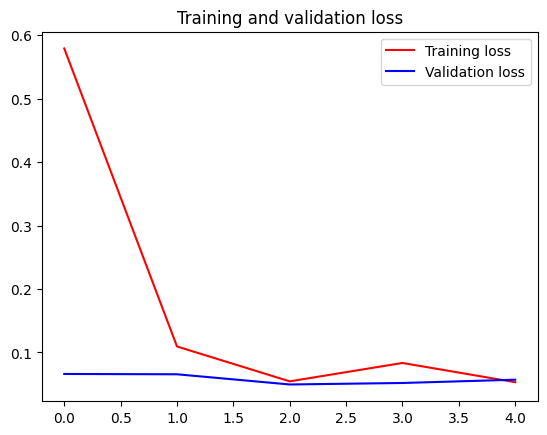

<Figure size 640x480 with 0 Axes>

In [462]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [463]:
import numpy as np

all_predictions = []
all_labels = []
for batch in tf_eval_dataset:
    logits = model.predict_on_batch(batch)["logits"]
    labels = batch["labels"]
    predictions = np.argmax(logits, axis=-1)
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue 
            all_predictions.append(predicted_idx) 
            all_labels.append(label_idx) 

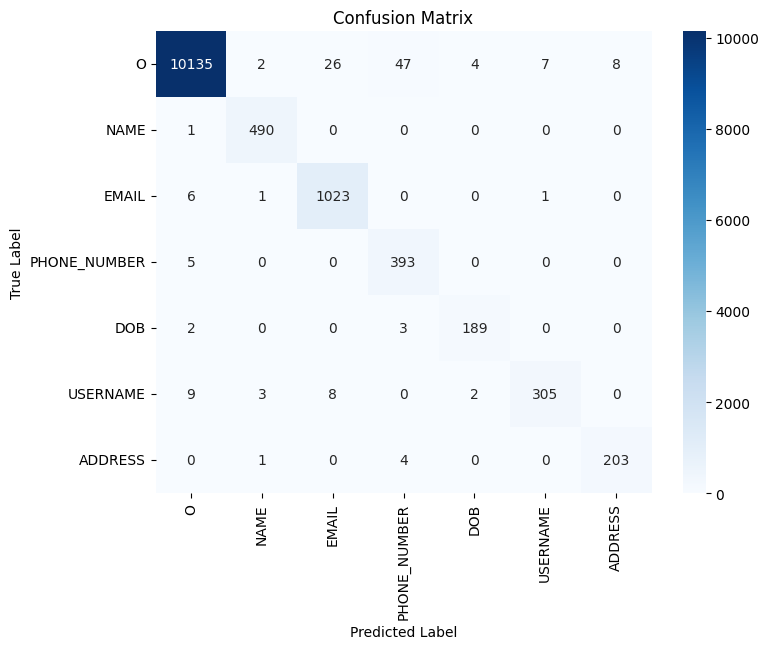

Classification Report:
              precision    recall  f1-score   support

           O       1.00      0.99      0.99     10229
        NAME       0.99      1.00      0.99       491
       EMAIL       0.97      0.99      0.98      1031
PHONE_NUMBER       0.88      0.99      0.93       398
         DOB       0.97      0.97      0.97       194
    USERNAME       0.97      0.93      0.95       327
     ADDRESS       0.96      0.98      0.97       208

    accuracy                           0.99     12878
   macro avg       0.96      0.98      0.97     12878
weighted avg       0.99      0.99      0.99     12878



In [464]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

conf_matrix = confusion_matrix(all_labels, all_predictions)

# 6. Visualize the Confusion Matrix with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=label_names))

We can see that the model struggles a bit on Phone numbers and Usernames. 

DOB as well could manifest in many variations and different formats and it may be wise for us to augment the data with more samples.

Usernames may also be highly variable and it makes sense to see them overlap with email addresses and names as they are often derivatives of the customers name. Email addresses have a very unique sequence of necessary sub parts, such as "@" and ".com" etc. thus it is not surprising that the model was able to identify these so well. 

Phone numbers could present problems as the examples overlap with other forms of PII or other general information that could include numbers.

### Application

Next I will demonstrate how we can potentially use this trained model to identify and then redact PII information contained within text. 

This method leverages the inbuilt methods contained within the tokenizer class from hugging face, we will be primarily relying on the character level index as this appears to be the most reliable concerning the position of the sub-words and special tokens.

It is important to note how an email is returned, as it is the decoder does not interpret punctuation contained within words to be part of those words, thus the parts of emails are actually assigned a separate index location. This makes it tricky to return a full email address within a single entity value.

In [465]:
def predict_token_ids(text):
    
    tokenized = tokenizer([text], return_tensors="np")
    preds = model(tokenized).logits
    classes = np.argmax(preds, axis=-1)[0]
    
    word_index = {word_id:[] for word_id in tokenized.word_ids()}
    
    for word_id, input_id in zip(tokenized.word_ids(), tokenized['input_ids'][0]):
        word_index[word_id] += [input_id]
        
    word_index = {key:[tokenizer.decode(val)] for key, val in word_index.items()}
    
    identified = {word_id:model.config.id2label[id] 
                  for word_id, id in zip(tokenized.word_ids(), classes) 
                  if model.config.id2label[id] != 'O'}
    
    results = [
        {'entity': value,
        'index': key,
        'word': word_index[key][0],
        'start': tokenized.word_to_chars(key)[0],
        'end': tokenized.word_to_chars(key)[1]}
        for key, value in identified.items() if key != None        
    ]
    
    return results

In [476]:
text = '''Host: Hello! How can I assist you today? 
Customer: I would like to update my address
Host: I can assist you with that, can you please confirm your name, email address, username and date of birth for me?
Customer: My name is Thandi Xoli and my username is thandix321 and my email is t.xoli@mail.com and my DOB is 1995/02/16'''

In [477]:
%%time
PII_Entities = predict_token_ids(text)

CPU times: total: 125 ms
Wall time: 127 ms


In [478]:
PII_Entities

[{'entity': 'NAME', 'index': 52, 'word': 'Thandi', 'start': 225, 'end': 231},
 {'entity': 'NAME', 'index': 53, 'word': 'Xoli', 'start': 232, 'end': 236},
 {'entity': 'USERNAME',
  'index': 58,
  'word': 'thandix321',
  'start': 256,
  'end': 266},
 {'entity': 'USERNAME', 'index': 63, 'word': 't', 'start': 283, 'end': 284},
 {'entity': 'EMAIL', 'index': 64, 'word': '.', 'start': 284, 'end': 285},
 {'entity': 'EMAIL', 'index': 65, 'word': 'xoli', 'start': 285, 'end': 289},
 {'entity': 'EMAIL', 'index': 66, 'word': '@', 'start': 289, 'end': 290},
 {'entity': 'EMAIL', 'index': 67, 'word': 'mail', 'start': 290, 'end': 294},
 {'entity': 'EMAIL', 'index': 68, 'word': '.', 'start': 294, 'end': 295},
 {'entity': 'EMAIL', 'index': 69, 'word': 'com', 'start': 295, 'end': 298},
 {'entity': 'DOB', 'index': 74, 'word': '1995', 'start': 313, 'end': 317},
 {'entity': 'DOB', 'index': 75, 'word': '/', 'start': 317, 'end': 318},
 {'entity': 'DOB', 'index': 76, 'word': '02', 'start': 318, 'end': 320},
 {'

Here we can see how we can use the tagged entities to obfuscate them within the text

This method uses a specific character to replace each value within the obfuscated text, the downside of this approach is that it retains information regarding the length of the word obfuscated. This is of course easy to replace with a different method if desired.

In [479]:
redacted_string = text

for i in range(len(PII_Entities)):
    redacted_string = redacted_string[:PII_Entities[i]['start']] + '#'*(PII_Entities[i]['end']-PII_Entities[i]['start']) + redacted_string[PII_Entities[i]['end']:]

In [481]:
print(redacted_string)

Host: Hello! How can I assist you today? 
Customer: I would like to update my address
Host: I can assist you with that, can you please confirm your name, email address, username and date of birth for me?
Customer: My name is ###### #### and my username is ########## and my email is ############### and my DOB is ##########
